In [1]:
%run twisted_graphene.py
from ipywidgets import interact,interact_manual
%config InlineBackend.figure_formats = ['svg']

Iremos usar todos os hoppings disponíveis conforme o estudo do PRB 93.235153, e avaliar o efeito da adição de campo elétrico dessa forma.

In [2]:
def find_VBM(bands):
    critical=np.max(bands[bands<=0])
    i,j=np.argwhere(bands==critical)[0]
    return i,j

def find_VBM_and_CBM(bands,Ktick):
    bands_left=bands[0:Ktick,:]
    bands_right=bands[Ktick::,:]
    VBmax_left_index,VBmax_left=find_VBM(bands_left)
    VBmax_right_index,VBmax_right=find_VBM(bands_right)
    VBmax_right_index+=Ktick
    CBmin_left_index,CBmin_left=find_VBM(-bands_left)
    CBmin_right_index,CBmin_right=find_VBM(-bands_right)
    CBmin_right_index+=Ktick
    return [VBmax_left_index,VBmax_right_index,CBmin_left_index,CBmin_right_index],[VBmax_left,VBmax_right,CBmin_left,CBmin_right]

In [3]:
def t_intra(x1,y1,x2,y2,max_distance=np.inf): #graphene intralayer hoppings
    a=2.46 #Angstrom
    x=x2-x1
    y=y2-y1
    r=np.sqrt(x**2+y**2)/a
    t=np.zeros_like(r)
    t[(0.3  < r) * (r < 0.8 )] = -2.8922   #1st neighbors = 0.5774
    t[(0.8  < r) * (r < 1.1 )] =  0.2425  #2nd neighbors = 1.0
    t[(1.1  < r) * (r < 1.3 )] = -0.2656  #3rd neighbors = 1.1547
    t[(1.3  < r) * (r < 1.6 )] =  0.0235  #4th neighbors = 1.5275
    t[(1.6  < r) * (r < 1.8 )] =  0.0524  #5th neighbors = 1.7321
    t[(1.8  < r) * (r < 2.05)] = -0.0209  #6th neighbors = 2.0
    t[(2.05 < r) * (r < 2.1 )] = -0.0148  #7th neighbors = 2.0817
    t[(2.1  < r) * (r < 2.35)] = -0.0211  #8th neighbors = 2.3094
    t[(r > max_distance)] = 0.0
    return t

In [7]:
@interact_manual(p=(0,10,1),q=(1,3,2),V=(0,2,0.1),Ef=(0,1,0.01),max_distance=(0.0,8.7,0.1),radius_norm=(0,0.5,0.1))
def plot(p=1,q=1,V=0.5,Ef=0.38,max_distance=8.7,radius_norm=0.2):
    g=TwistedBilayerGraphene(p,q)
    g.calc_hops(max_distance,t_intra=t_intra)

    G,M,K=g.Gamma,g.M[0],g.K[0]
    versor=lambda p1,p2: (p2-p1)/np.linalg.norm(p2-p1)
    radius=radius_norm*np.linalg.norm(g.G1)
    _kpoints=[K+radius*versor(K,M),K,K+radius*versor(K,G)]
    g.set_kpath(_kpoints,[50,50])
    _kpoints=np.array(_kpoints)
    Ktick=g.kticks[1]
    g.ell=g.ell-g.ell[Ktick]

    g.set_hamiltonian(1.0,0.0)
    g.calc_bands(4,-Ef)
    g.bands0=g.bands+Ef
    
    g.set_hamiltonian(1.0,V)
    g.calc_bands(4,-Ef)
    g.bands1=g.bands+Ef
    
    #plot brillouin zone
    plt.figure(figsize=(11.4,4.8))
    plt.subplot(121)
    vertices=np.array([g.K[0],g.Kp[0],g.K[1],g.Kp[1],g.K[2],g.Kp[2],g.K[0]])
    plt.plot([0,g.G1[0]],[0,g.G1[1]],'k-')
    plt.plot([0,g.G2[0]],[0,g.G2[1]],'k-')
    plt.plot(vertices[:,0],vertices[:,1],'k--')
    plt.plot(_kpoints[:,0],_kpoints[:,1],'o-',lw=2)
    plt.axis('equal')
    plt.xlabel(r'$k_x$ [$Å^{-1}$]')
    plt.ylabel(r'$k_y$ [$Å^{-1}$]')
#     plt.show()    

    #plot bands
    plt.subplot(122)
    plt.plot(g.ell,g.bands0,'.',color='tab:blue')
    plt.plot(g.ell,g.bands1,'.',color='tab:orange')

#     #plot Dirac points
#     x,y=find_VBM_and_CBM(g.bands0,Ktick)
#     plt.plot(g.ell[x],g.bands0[x,y],'ko')
#     x,y=find_VBM_and_CBM(g.bands1,Ktick)
#     plt.plot(g.ell[x],g.bands1[x,y],'ko')    
    
    plt.xlim((g.ell[0],g.ell[-1]))
    plt.ylim((-1.0,1.0))
    plt.ylabel('Energy [eV]')
    plt.xticks([-radius,0,radius],['M$\\leftarrow$','K','$\\rightarrow\Gamma$'])
    plt.grid(True)
    plt.savefig(f'g{p}{q}_electric_field.png',dpi=300)
    plt.show()

interactive(children=(IntSlider(value=1, description='p', max=10), IntSlider(value=1, description='q', max=3, …

In [12]:
np.sqrt(3.35**2+2.46**2/3)

3.638639855770285

Aparentemente, não ocorre abertura de gap! Podemos avaliar a dependência do deslocamento dos pontos de Dirac com o campo elétrico.

In [152]:
g=TwistedBilayerGraphene(1,1)
g.calc_hops(8.7)

G,M,K=g.Gamma,g.M[0],g.K[0]
versor=lambda p1,p2: (p2-p1)/np.linalg.norm(p2-p1)
radius=0.2*np.linalg.norm(g.G1)
g.set_kpath([K+radius*versor(K,M),K,K+radius*versor(K,G)],[50,50])
Ktick=g.kticks[1]
g.ell=g.ell-g.ell[Ktick]

/home/vgmdu/MEGA/Mestrado/twistrônica/code/twisted_graphene.py:144: RuntimeWarning: invalid value encountered in true_divide
  cos3=l1*c3(xx)-l2*c3(xx*np.cos(theta)+yy*np.sin(theta)) #termo chato que muda de sinal dependendo da sub-rede
/home/vgmdu/MEGA/Mestrado/twistrônica/code/twisted_graphene.py:145: RuntimeWarning: invalid value encountered in true_divide
  cos6=c6(xx)+c6(xx*np.cos(theta)+yy*np.sin(theta)) #termo par, não depende da sub-rede


In [154]:
VV=np.linspace(0,1.8,19)
bands={}
for V in VV:
    g.set_hamiltonian(interlayer=True,V=V)
    g.calc_bands(4,-0.3804)
    bands[V]=g.bands+0.3804

In [155]:
y=[]
for V in VV:
    i,j=find_VBM_and_CBM(bands[V],Ktick)
    y.append(np.sort(g.ell[i]))
y=np.array(y)-g.ell[Ktick]
y

array([[-0.00445887, -0.00445887,  0.        ,  0.00445887],
       [-0.01337662, -0.00891775,  0.00891775,  0.01337662],
       [-0.02229436, -0.01783549,  0.01783549,  0.02229436],
       [-0.03121211, -0.02675324,  0.02675324,  0.03121211],
       [-0.03567098, -0.03567098,  0.03121211,  0.03567098],
       [-0.04458873, -0.04458873,  0.04012986,  0.04458873],
       [-0.05350648, -0.05350648,  0.0490476 ,  0.05350648],
       [-0.06242422, -0.06242422,  0.05796535,  0.06242422],
       [-0.07580084, -0.07580084,  0.06688309,  0.07134197],
       [-0.08471859, -0.08025971,  0.07580084,  0.08025971],
       [-0.09363633, -0.08917746,  0.08471859,  0.08917746],
       [-0.10701295, -0.10255408,  0.09363633,  0.09809521],
       [-0.1159307 , -0.11147182,  0.10255408,  0.10701295],
       [-0.12484844, -0.1159307 ,  0.11147182,  0.1159307 ],
       [-0.13822506, -0.12930732,  0.12038957,  0.12484844],
       [-0.14714281, -0.13822506,  0.12484844,  0.12930732],
       [-0.16051943, -0.

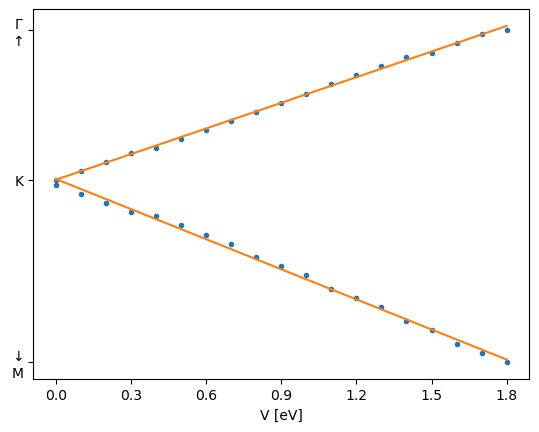

In [156]:
y1=y[:,0]
plt.plot(VV,y1,'.')
y2=y[:,2]
plt.plot(VV,y2,'.',color='tab:blue')

m1,b1=np.polyfit(VV,y1,1)
m2,b2=np.polyfit(VV,y2,1)

plt.plot(VV,m1*VV+b1)
plt.plot(VV,m2*VV+b2,color='tab:orange')

plt.xticks(VV[::3])
plt.xlabel('V [eV]')
plt.yticks([0,min(np.min(y1),np.min(y2)),max(np.max(y1),np.max(y2))],['K','$\\downarrow$\nM','$\Gamma$\n$\\uparrow$'])
plt.show()